<a href="https://colab.research.google.com/github/LeeMinJun0102/Car_Price_Predict/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q tensorflow opencv-python-headless scikit-learn matplotlib pillow

# Import

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import cv2

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
from google.colab import files
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.resnet50 import preprocess_input

print("✅ 모든 라이브러리 설치 및 import 완료!")

✅ 모든 라이브러리 설치 및 import 완료!


# 1 colab drive 연결

In [ ]:
from google.colab import drive
print("🔗 Google Drive에 연결 중...")
drive.mount('/content/drive')

🔗 Google Drive에 연결 중...
Mounted at /content/drive


In [ ]:
# google drive 연결
def google_drive():
    # Drive 내 car_data 폴더 경로
    source_path = '/content/drive/MyDrive/itwill_Final_Project/car_data'

    if os.path.exists(source_path):  # 👈 이 부분 수정!
        print(f"📁 Drive 내 데이터 위치 : {source_path}")

        # 빠른 처리를 위해 로컬로 복사
        if os.path.exists('./car_data'):
            shutil.rmtree('./car_data')

        print("📋 데이터를 로컬로 복사 중... (시간이 소요될 수 있습니다)")
        shutil.copytree(source_path, './car_data')
        print("✅ 데이터 복사 완료!")

    else:
        print("❌ Google Drive에서 car_data 폴더를 찾을 수 없습니다.")
        return False  # 👈 False 반환 추가

    check_data_structure()

    # models 폴더 생성
    os.makedirs('car_data/models', exist_ok=True)

    return True

# 데이터 구조 확인 함수
def check_data_structure():
    """업로드된 데이터 구조 확인"""
    print("\n📊 업로드된 데이터 구조 확인:")

    train_dir = 'car_data/train'

    if not os.path.exists(train_dir):
        print("❌ car_data/train 폴더가 없습니다!")
        return False

    total_images = 0
    brands = []

    for brand in os.listdir(train_dir):
        brand_path = os.path.join(train_dir, brand)

        if os.path.isdir(brand_path):
            image_files = [f for f in os.listdir(brand_path)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            image_count = len(image_files)

            print(f"  📁 {brand}: {image_count}장")
            total_images += image_count
            brands.append(brand)

    print(f"\n✅ 총 {len(brands)}개 브랜드, {total_images}장의 이미지")

    # 최소 요구사항 체크
    if len(brands) < 3:
        print("⚠️ 최소 3개 이상의 브랜드가 필요합니다.")

    if total_images < 300:
        print("⚠️ 전체 이미지가 300장 미만입니다. 더 많은 데이터가 권장됩니다.")

    return total_images > 0

# 실행
print("Google Drive 연결")
google_drive()

Google Drive 연결
📁 Drive 내 데이터 위치 : /content/drive/MyDrive/itwill_Final_Project/car_data
📋 데이터를 로컬로 복사 중... (시간이 소요될 수 있습니다)
✅ 데이터 복사 완료!

📊 업로드된 데이터 구조 확인:
  📁 Volvo_front: 150장
  📁 Grandeur_front: 150장
  📁 Hyundai: 150장
  📁 BMW: 150장
  📁 Grandeur_back: 150장
  📁 Porsche_front: 150장
  📁 Morning_front: 150장
  📁 Porsche_back: 150장
  📁 Genesis: 150장
  📁 Mercedes: 150장
  📁 Morning_back: 150장
  📁 Volvo_back: 150장
  📁 Tesla_back: 150장
  📁 Audi: 150장
  📁 Tesla_front: 150장

✅ 총 15개 브랜드, 2250장의 이미지


True

# 2 전처리 -> 수정하면서 사용

In [ ]:
def preprocess_image(image, img_size=(224, 224)):
    """
    ResNet50 전이학습을 위한 올바른 전처리 (TensorFlow 버전)

    Args:
        image: BGR 형식의 원본 이미지
        img_size: 출력 이미지 크기

    Returns:
        전처리된 이미지 (ResNet50 호환)
    """
    # BGR to RGB 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 리사이징
    image_resized = cv2.resize(image_rgb, img_size)

    # ResNet50 전용 전처리 적용
    # 내부적으로 ImageNet 정규화 수행
    image_preprocessed = preprocess_input(image_resized.astype(np.float32))

    return image_preprocessed

# 3 데이터 로딩 및 처리 함수

In [ ]:
# 2. 데이터 로딩 및 처리 함수
def complete_data_processor(data_dir, img_size=(224, 224)):
    """향상된 전처리가 포함된 데이터 처리"""

    print("\n📊 데이터 구조 확인 및 처리 중...")

    if not os.path.exists(data_dir):
        print("❌ 데이터 폴더가 없습니다!")
        return None, None, None

    images = []
    labels = []
    brand_info = {}
    sample_images = {}

    # 한 번의 순회로 모든 작업 처리
    for brand in os.listdir(data_dir):
        brand_path = os.path.join(data_dir, brand)

        if os.path.isdir(brand_path):
            print(f"  📁 {brand} 처리 중...")
            brand_count = 0
            first_image_for_display = None

            for img_file in os.listdir(brand_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(brand_path, img_file)

                    try:
                        image = cv2.imread(img_path)
                        if image is not None:
                            # 샘플 표시용 (전처리 전 원본 - BGR to RGB만)
                            if first_image_for_display is None:
                                first_image_for_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                            # ✨ 전처리 함수 호출
                            image_processed = preprocess_image(image, img_size)

                            images.append(image_processed)
                            labels.append(brand)
                            brand_count += 1

                    except Exception as e:
                        print(f"    ⚠️ 이미지 처리 실패 {img_file}: {e}")

            # 브랜드별 정보 저장
            if brand_count > 0:
                brand_info[brand] = brand_count
                if first_image_for_display is not None:
                    sample_images[brand] = first_image_for_display

            print(f"    ✅ {brand}: {brand_count}장 완료")

    # 데이터 구조 리포트
    total_images = sum(brand_info.values())
    print(f"\n✅ 총 {len(brand_info)}개 브랜드, {total_images}장의 이미지")

    # 최소 요구사항 체크
    if len(brand_info) < 3:
        print("⚠️ 최소 3개 이상의 브랜드가 필요합니다.")
    if total_images < 300:
        print("⚠️ 전체 이미지가 300장 미만입니다.")

    # 샘플 이미지 표시
    if sample_images:
        display_samples_unified(sample_images, brand_info)

    # 데이터 처리 완료
    if len(images) > 0:
        images = np.array(images)
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        categorical_labels = to_categorical(encoded_labels)

        print(f"✅ 모든 처리 완료: {len(images)}장, {len(label_encoder.classes_)}개 클래스")
        print(f"✅ 클래스: {list(label_encoder.classes_)}")

        return images, categorical_labels, label_encoder.classes_

    return None, None, None

# 4 샘플 이미지 표시 함수

In [ ]:
def display_samples_unified(sample_images, brand_info):
    """통합된 샘플 이미지 표시"""
    brands = list(sample_images.keys())
    n_show = min(6, len(brands))
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, brand in enumerate(brands[:n_show]):
        axes[i].imshow(sample_images[brand])
        axes[i].set_title(f'{brand}\n(count : {brand_info[brand]})')
        axes[i].axis('off')

    for i in range(n_show, 6):
        axes[i].axis('off')

    plt.suptitle('Data Structure & Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

# 5 전처리 적용


📊 데이터 구조 확인 및 처리 중...
  📁 Volvo_front 처리 중...
    ✅ Volvo_front: 150장 완료
  📁 Grandeur_front 처리 중...
    ✅ Grandeur_front: 150장 완료
  📁 Hyundai 처리 중...
    ✅ Hyundai: 150장 완료
  📁 BMW 처리 중...
    ✅ BMW: 150장 완료
  📁 Grandeur_back 처리 중...
    ✅ Grandeur_back: 150장 완료
  📁 Porsche_front 처리 중...
    ✅ Porsche_front: 150장 완료
  📁 Morning_front 처리 중...
    ✅ Morning_front: 150장 완료
  📁 Porsche_back 처리 중...
    ✅ Porsche_back: 150장 완료
  📁 Genesis 처리 중...
    ✅ Genesis: 150장 완료
  📁 Mercedes 처리 중...
    ✅ Mercedes: 150장 완료
  📁 Morning_back 처리 중...
    ✅ Morning_back: 150장 완료
  📁 Volvo_back 처리 중...
    ✅ Volvo_back: 150장 완료
  📁 Tesla_back 처리 중...
    ✅ Tesla_back: 150장 완료
  📁 Audi 처리 중...
    ✅ Audi: 150장 완료
  📁 Tesla_front 처리 중...
    ✅ Tesla_front: 150장 완료

✅ 총 15개 브랜드, 2250장의 이미지


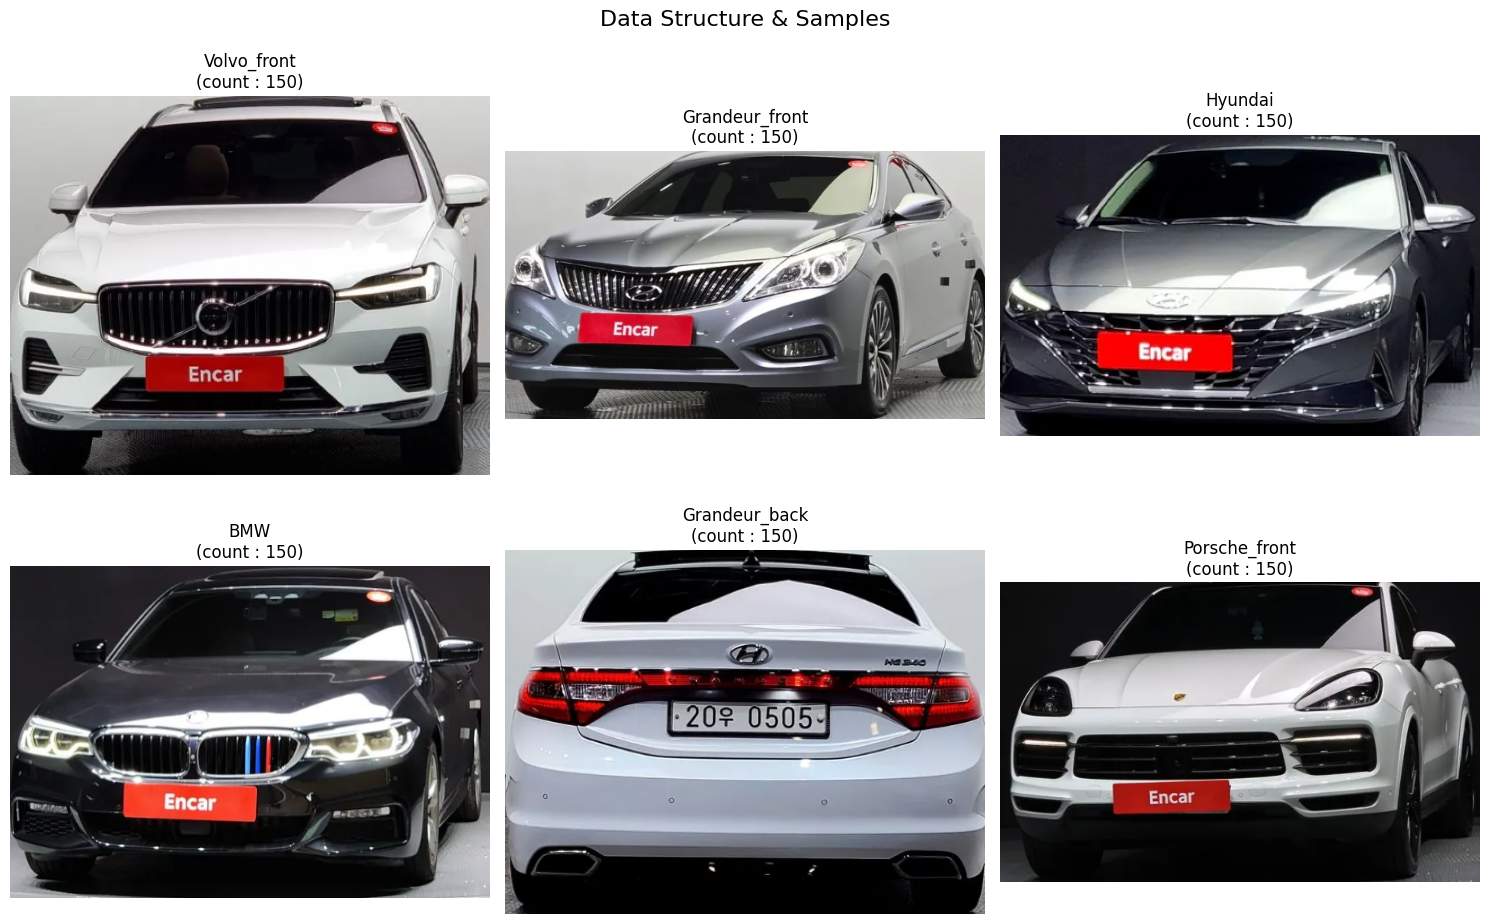

✅ 모든 처리 완료: 2250장, 15개 클래스
✅ 클래스: [np.str_('Audi'), np.str_('BMW'), np.str_('Genesis'), np.str_('Grandeur_back'), np.str_('Grandeur_front'), np.str_('Hyundai'), np.str_('Mercedes'), np.str_('Morning_back'), np.str_('Morning_front'), np.str_('Porsche_back'), np.str_('Porsche_front'), np.str_('Tesla_back'), np.str_('Tesla_front'), np.str_('Volvo_back'), np.str_('Volvo_front')]

🎉 향상된 전처리로 모든 처리 완료! 모델 학습 준비됨


In [ ]:
images, labels, class_names = complete_data_processor('car_data/train')
if images is not None:
    print("\n🎉 향상된 전처리로 모든 처리 완료! 모델 학습 준비됨")

# 6 모델 생성

In [ ]:
def create_car_model(num_classes, learning_rate=0.0001):
    print("모델 생성 중...")

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 레이어 동결 (170개 중 마지막 30개만 우리의 이미지에 맞게 학습)
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', name='feature_dense'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax', name='predictions')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']  # 메트릭스 추가
    )

    print(f"모델 완성: {len(class_names)}개 클래스")
    return model

if 'class_names' in locals() and class_names is not None:
    model = create_car_model(num_classes=len(class_names))
    model.summary()
else:
    print('데이터를 먼저 로드해주세요')

모델 생성 중...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
모델 완성: 15개 클래스


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_dense (Dense)           │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,771,983 (94.50 MB)

 Trainable params: 15,634,447 (59.64 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

# 7 모델 학습 및 성능 평가

훈련 시작!
Epoch 1/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.3357 - loss: 2.2218 - top_k_categorical_accuracy: 0.6280

56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 697ms/step - accuracy: 0.3402 - loss: 2.2089 - top_k_categorical_accuracy: 0.6313 - val_accuracy: 0.9509 - val_loss: 0.1791 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 2/25
 1/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 1.0000 - loss: 0.2415 - top_k_categorical_accuracy: 1.0000

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 1.0000 - loss: 0.2415 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9554 - val_loss: 0.1658 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 3/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9677 - loss: 0.1851 - top_k_categorical_accuracy: 0.9981

56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 468ms/step - accuracy: 0.9679 - loss: 0.1842 - top_k_categorical_accuracy: 0.9981 - val_accuracy: 0.9933 - val_loss: 0.0488 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 4/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0682 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9933 - val_loss: 0.0490 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 5/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 455ms/step - accuracy: 0.9909 - loss: 0.0517 - top_k_categorical_accuracy: 0.9990 - val_accuracy: 0.9933 - val_loss: 0.0473 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 6/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9688 - loss: 0.0647 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9933 - val_loss: 0.0471 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 7/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9956 - lo

56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 466ms/step - accuracy: 0.9956 - loss: 0.0224 - top_k_categorical_accuracy: 0.9995 - val_accuracy: 0.9978 - val_loss: 0.0401 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 8/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0454 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9978 - val_loss: 0.0397 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 9/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - accuracy: 0.9974 - loss: 0.0202 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9955 - val_loss: 0.0398 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 10/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0059 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9978 - val_loss: 0.0401 - val_top_k_categorical_accuracy: 0.9978 - learning_rate: 1.0000e-04
Epoch 11/25
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - accuracy: 0.9953 -

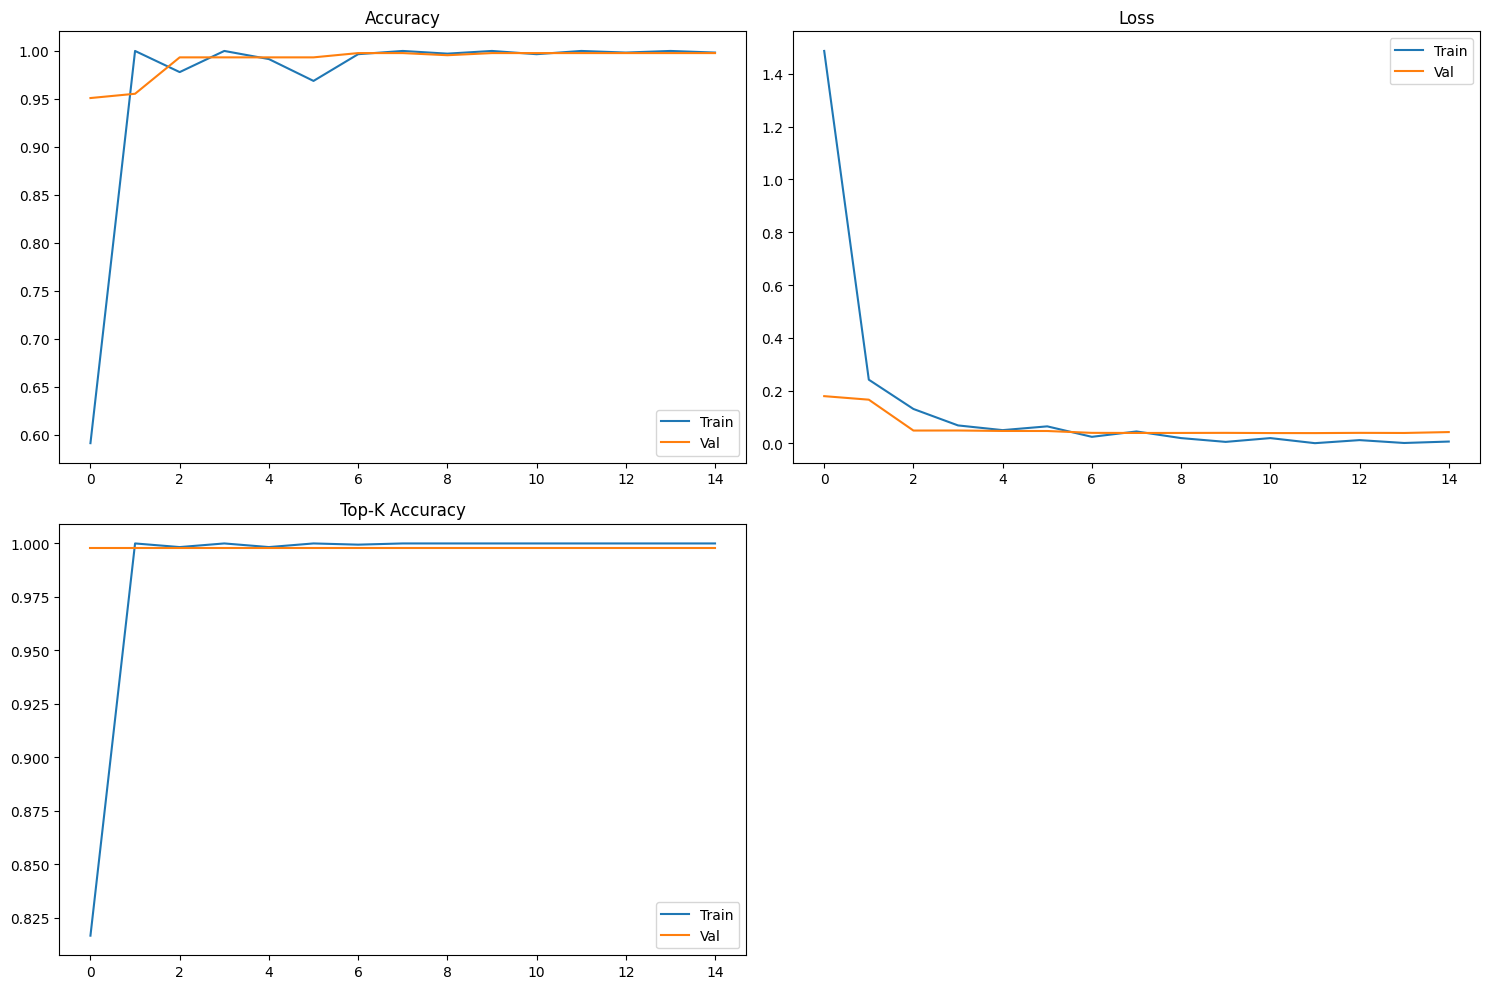

최고 검증 정확도: 0.9978


In [ ]:
def simple_train_model(model, images, labels, epochs=25):
    """간단한 모델 훈련"""
    print('훈련 시작!')

    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(
        images, labels, test_size=0.2, random_state=42,
        stratify=np.argmax(labels, axis=1)
    )

    # 데이터 증강
    train_gen = ImageDataGenerator(
        rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,
        zoom_range=0.15, horizontal_flip=True, brightness_range=[0.8, 1.2]
    )
    val_gen = ImageDataGenerator()

    # 콜백
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
        tf.keras.callbacks.ModelCheckpoint('car_data/models/best_car_model.h5', monitor='val_accuracy', save_best_only=True)
    ]

    # 훈련
    history = model.fit(
        train_gen.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=len(X_train) // 32,
        epochs=epochs,
        validation_data=val_gen.flow(X_val, y_val, batch_size=32),
        validation_steps=len(X_val) // 32,
        callbacks=callbacks
    )

    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0,0].plot(history.history['accuracy'], label='Train')
    axes[0,0].plot(history.history['val_accuracy'], label='Val')
    axes[0,0].set_title('Accuracy')
    axes[0,0].legend()

    axes[0,1].plot(history.history['loss'], label='Train')
    axes[0,1].plot(history.history['val_loss'], label='Val')
    axes[0,1].set_title('Loss')
    axes[0,1].legend()

    if 'top_k_categorical_accuracy' in history.history:
        axes[1,0].plot(history.history['top_k_categorical_accuracy'], label='Train')
        axes[1,0].plot(history.history['val_top_k_categorical_accuracy'], label='Val')
        axes[1,0].set_title('Top-K Accuracy')
        axes[1,0].legend()

    axes[1,1].axis('off')
    plt.tight_layout()
    plt.show()

    # 결과 출력
    final_acc = max(history.history['val_accuracy'])
    print(f"최고 검증 정확도: {final_acc:.4f}")

    return history, X_val, y_val

# 실행
if 'model' in locals() and 'images' in locals():
    history, X_val, y_val = simple_train_model(model, images, labels)
else:
    print("모델과 데이터를 먼저 준비해주세요.")

# 8 이미지 유사도 검색

데이터베이스 구축 중...
완료: 2250개 이미지


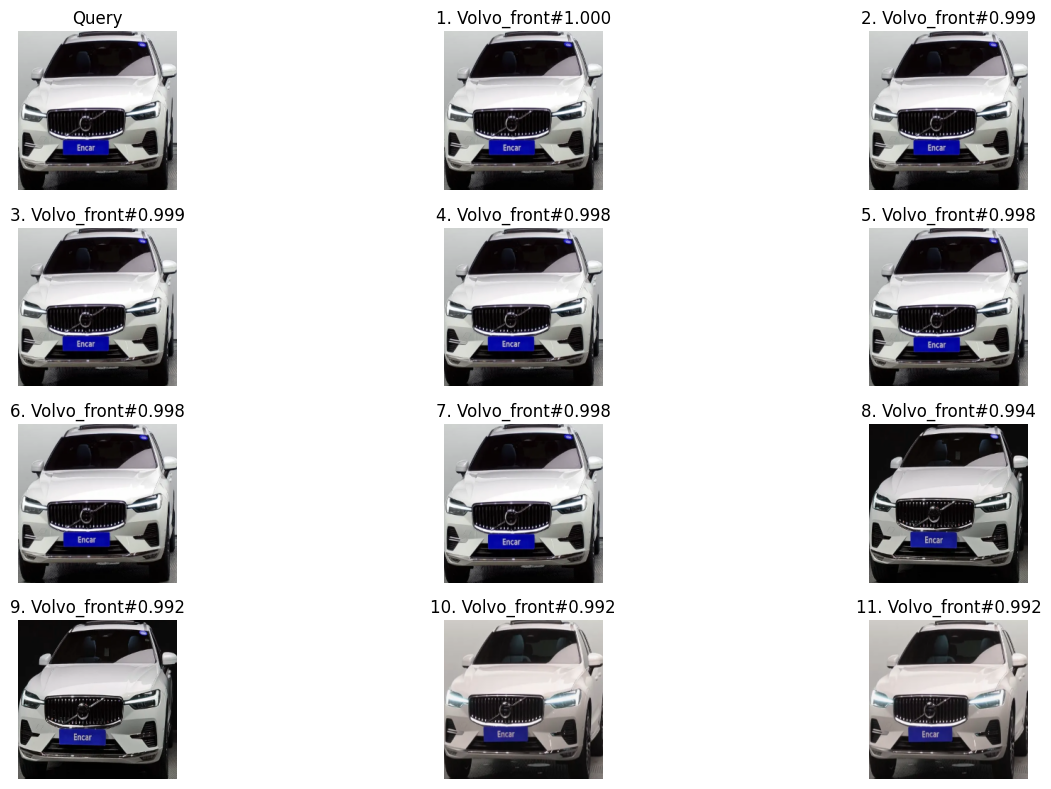

1위: Volvo_front (유사도: 1.000)
2위: Volvo_front (유사도: 0.999)
3위: Volvo_front (유사도: 0.999)
4위: Volvo_front (유사도: 0.998)
5위: Volvo_front (유사도: 0.998)
6위: Volvo_front (유사도: 0.998)
7위: Volvo_front (유사도: 0.998)
8위: Volvo_front (유사도: 0.994)
9위: Volvo_front (유사도: 0.992)
10위: Volvo_front (유사도: 0.992)
11위: Volvo_front (유사도: 0.992)


In [ ]:
def create_search_system(model, class_names):
    # Sequential 모델에서 'feature_dense' 레이어 찾기
    feature_layer = None
    for layer in model.layers:
        if hasattr(layer, 'name') and layer.name == 'feature_dense':
            feature_layer = layer
            break

    if feature_layer is None:
        # 대안: Dense 512 레이어 찾기
        for layer in model.layers:
            if hasattr(layer, 'units') and layer.units == 512:
                feature_layer = layer
                break

    # feature_dense 레이어까지의 모델 생성
    feature_model = tf.keras.Sequential()
    for layer in model.layers:
        feature_model.add(layer)
        if layer == feature_layer:
            break

    return feature_model

def build_database(feature_model, images, labels):
    print("데이터베이스 구축 중...")
    db_features = feature_model.predict(images, verbose=0)
    db_labels = np.argmax(labels, axis=1)
    print(f"완료: {len(images)}개 이미지")
    return db_features, db_labels, images

def search_similar(query_image, feature_model, db_features, db_labels, db_images, class_names, top_k=11):
    # 쿼리 이미지 특징 추출
    if len(query_image.shape) == 3:
        query_image = np.expand_dims(query_image, 0)
    query_features = feature_model.predict(query_image, verbose=0)

    # 유사도 계산
    similarities = cosine_similarity(query_features, db_features)[0]
    top_idx = np.argsort(similarities)[::-1][:top_k]

    # 결과
    results = []
    for i, idx in enumerate(top_idx):
        results.append({
            'rank': i+1,
            'car': class_names[db_labels[idx]],
            'similarity': similarities[idx],
            'image': db_images[idx]
        })
    return results

def show_results(query_image, results):
    fig, axes = plt.subplots(4, 3, figsize=(15, 8))
    axes = axes.flatten()

    # 쿼리 이미지 역정규화
    query_denorm = query_image.copy()
    query_denorm[..., 0] += 103.939  # B
    query_denorm[..., 1] += 116.779  # G
    query_denorm[..., 2] += 123.68   # R
    query_denorm = np.clip(query_denorm, 0, 255).astype(np.uint8)

    axes[0].imshow(query_denorm)
    axes[0].set_title('Query')
    axes[0].axis('off')

    for i, r in enumerate(results[:11]):
        # 결과 이미지 역정규화
        result_img = r['image'].copy()
        result_img[..., 0] += 103.939  # B
        result_img[..., 1] += 116.779  # G
        result_img[..., 2] += 123.68   # R
        result_img = np.clip(result_img, 0, 255).astype(np.uint8)

        axes[i+1].imshow(result_img)
        axes[i+1].set_title(f"{r['rank']}. {r['car']}#{r['similarity']:.3f}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# 사용법
if 'model' in locals() and 'images' in locals():
    feature_model = create_search_system(model, class_names)
    db_features, db_labels, db_images = build_database(feature_model, images, labels)

    query = images[0]
    results = search_similar(query, feature_model, db_features, db_labels, db_images, class_names)
    show_results(query, results)

    for r in results:
        print(f"{r['rank']}위: {r['car']} (유사도: {r['similarity']:.3f})")

# 9 이미지 테스트

In [ ]:
def upload_test():
    """개선된 업로드 테스트"""
    from google.colab import files
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        img = cv2.imread(filename)

        # ⭐ 통합 전처리 함수 사용
        processed = preprocess_image(img)

        results = search_similar(processed, feature_model, db_features, db_labels, db_images, class_names)
        show_results(processed, results)

        print(f"가장 유사한 차량: {results[0]['car']}")
        return processed
    return None

def batch_test(test_images, test_labels):
    """일괄 평가"""
    correct_top1 = correct_top3 = 0

    for img, label in zip(test_images, test_labels):
        true_class = class_names[np.argmax(label)]
        results = search_similar(img, feature_model, db_features, db_labels, db_images, class_names)

        pred_classes = [r['car'] for r in results]
        if true_class == pred_classes[0]:
            correct_top1 += 1
        if true_class in pred_classes[:3]:
            correct_top3 += 1

    total = len(test_images)
    print(f"Top-1 정확도: {correct_top1/total:.3f}")
    print(f"Top-3 정확도: {correct_top3/total:.3f}")

# 사용법
if 'feature_model' in locals() and 'db_features' in locals():
    # 업로드 테스트
    upload_test()

    # 검증 데이터 평가
    if 'X_val' in locals():
        batch_test(X_val[:20], y_val[:20])